In [1]:
import os, argparse, pickle, librosa, joblib
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from scipy.io.wavfile import write
from scipy.io import savemat
import matplotlib.pyplot as plt
import torch
from glob import glob
from eval_utils import *
from utils import snd_denormalizer, acc_normalizer
import models
import IPython.display as ipd
from tqdm import tqdm
from params import get_arg

/root/anaconda3/envs/1.7/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


# 보낼 거
## filt(accel), filt(sound), y, y', filt 코드(사용법첨부)

In [2]:
config = get_arg(['--len', '512', '--latency', '24', '--b', '0', '--loss_weight', '1', '--loss', 'l1', '--name', 'cnn_dynamic_len512_lr0.001_notanh'])

SR = 8192
WINDOW_SIZE = 500 # us
data_length = config.len
BATCH_SIZE = config.batch
K, m = 8, 8
ls = 128

In [3]:
ABSpath = '/root/te'
path = os.path.join(ABSpath, 'ai_model/pytorch/test_model')
data_path = os.path.join(ABSpath,'ai_model/pytorch/test_model')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
accel_raw_data = joblib.load(open(os.path.join(data_path,'stationary_accel_train.joblib'),'rb'))
sound_raw_data = joblib.load(open(os.path.join(data_path,'stationary_sound_train.joblib'),'rb'))
transfer_f = np.array(pickle.load(open(os.path.join(data_path,'transfer_f.pickle'),'rb')))
transfer_f = torch.tensor(transfer_f[::-1,:,:].copy(),device=device)
transfer_f.requires_grad = False

In [4]:
class testDataset(Dataset):
    def __init__(self, accel, sound, config):
        self.config = config
        self.accel = torch.from_numpy(np.array(self.flatten(accel)))
        self.sound = torch.from_numpy(np.array(self.flatten(sound)))
        
        self.mode = 'end'

        self.mode = 'center' # split place of out
        self.index = torch.arange(0, len(self.sound), self.config.len)
        # self.accel = self.split(self.accel)
        # self.sound = self.split(self.sound)

    def flatten(self, data):
        return [x for y in data for x in y]

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        index = self.index[idx]
        frame_size = self.config.b
        if self.config.future:
            frame_size += self.config.len
        # sound_index = index + frame_size + self.config.latency + (self.config.len // 2)
        sound_index = index + frame_size + self.config.latency
        
        accel = self.accel[index:index + frame_size]
        
        sound = self.sound[sound_index:sound_index + self.config.len]
        if accel.size(0) != frame_size:
            accel = torch.cat([accel,torch.zeros((frame_size - accel.size(0), accel.size(1)), device=accel.device, dtype=accel.dtype)])
        if sound.size(0) != self.config.len:
            sound = torch.cat([sound,torch.zeros((self.config.len - sound.size(0), sound.size(1)), device=sound.device, dtype=sound.dtype)])
        return accel.transpose(0,1), sound

#     def split(self, data, start, end):
#         if len(data.shape) == 2:
#             return data[start:end]
#         elif len(data.shape) == 3:
#             return data[:,start:end]

In [5]:
config.split_num = config.len
dataset = testDataset(accel_raw_data, sound_raw_data, config)
# dataset = makeDataset(accel_raw_data, sound_raw_data, config, train=False)
if config.norm:
    snd_denorm = snd_denormalizer(config)
    acc_norm = acc_normalizer(config)
if config.name == '':
    name = f'{config.model}'
    name += f'_b{config.b}_d{data_length}' if config.feature == 'wav' else ''
    name += f'_lat{config.latency}_{config.opt}_{config.lr}_decay{config.decay:0.4}'
    name += f'_feature{config.feature}_{config.loss}'
    if config.feature == 'mel':
        name += f'_nfft{config.nfft}'
    if config.relu:
        name += '_relu'
    if config.future:
        name += '_future'
    if config.diff:
        name += f'_{config.diff}'
        name += f'_weight{config.loss_weight}'
    if config.subtract:
        name += f'_subtract'
    if config.norm:
        name += '_norm'
else:
    name = config.name
print(name)
modelsavepath = sorted(glob(os.path.join(path, 'model_save/'+name + '/*')), key=lambda x: float(os.path.basename(x).split('.pt')[0].split('_')[-1]))[1]
if config.feature == 'wav':
    model = getattr(models, config.model)(dataset[0][0].shape[1:], dataset[0][1].shape[1:], dataset[0][0].shape[0], dataset[0][1].shape[0], config).to(device)
elif config.feature == 'mel':
    model = getattr(models, config.model)((config.nmels, 12), (config.len,), (config.len + config.b) // (config.nfft // 2) + 1, 8, config).to(device)

cnn_dynamic_len512_lr0.001_notanh


In [6]:
print(modelsavepath)
model.load_state_dict(torch.load(modelsavepath)['model'])
dataset_generator = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

/root/te/ai_model/pytorch/test_model/model_save/cnn_dynamic_len512_lr0.001_notanh/7_0.0_1.085.pt


In [7]:
config.range = '90~100'
config.filter = False
filt = bandPassFilter(config)


data_res, sound_res = [], []
y = []
x = []
model.eval()
with torch.no_grad():
    for data, sound in tqdm(dataset_generator):
        if config.filter:
            sound = filt(sound.to(device)).cpu()
        sound_res.append(sound)
        
        data = data.to(device)
        if config.norm:
            data = acc_norm(data)
        if config.filter:
            data = filt(data)
            x.append(data.clone().cpu())
            
        if config.feature == 'stft':
            data = list(map(stft, data))
            data = torch.stack(data)
            data = torch.cat([data.real, data.imag], 1)
            
        res = model(data)
        
        if config.feature == 'stft':
            y = torch.stack([res[:,:res.shape[1]//2],res[:,res.shape[1]//2:]],-1)
            
            y = list(map(istft, y))
            res = torch.stack(y,0).transpose(2,1)
            
#         data_res.append(conv_with_S(model(data.to(device)), S_data=transfer_f, device=device, config=config).cpu()[:,0,:])
        res = conv_with_S(res, S_data=transfer_f, device=device, config=config)
        if config.norm:
            res = snd_denorm(res)
        data_res.append(res.cpu())
#         data_res.append(dataset.split(res, config.len // 2 - (config.split_number // 2), config.len // 2 + (config.split_number // 2)))

        



100%|██████████| 1221/1221 [01:23<00:00, 14.67it/s]


In [8]:
from time import time
with torch.no_grad():
    for data, sound in dataset_generator:
        st= time()
        model(data[:1].to(device))
        print(time() - st)
        break

0.0006246566772460938


In [9]:
start_time = config.b+config.len+config.latency+(config.len // 2)-config.split_number
len(sound) - start_time, len(sound_res)

(-504, 1221)

In [10]:
data_res = torch.cat(data_res)
sound_res = torch.cat(sound_res)
data_res = torch.reshape(data_res, (-1,data_res.size(-1)))
sound_res = torch.reshape(sound_res, (-1,data_res.size(-1)))


In [11]:
data_res = - data_res

In [12]:
# 새로 학습시킨 건 이 코드 제외
# data_res = data_res[200:]
# sound_res = sound_res[:-200]

<Figure size 432x288 with 0 Axes>

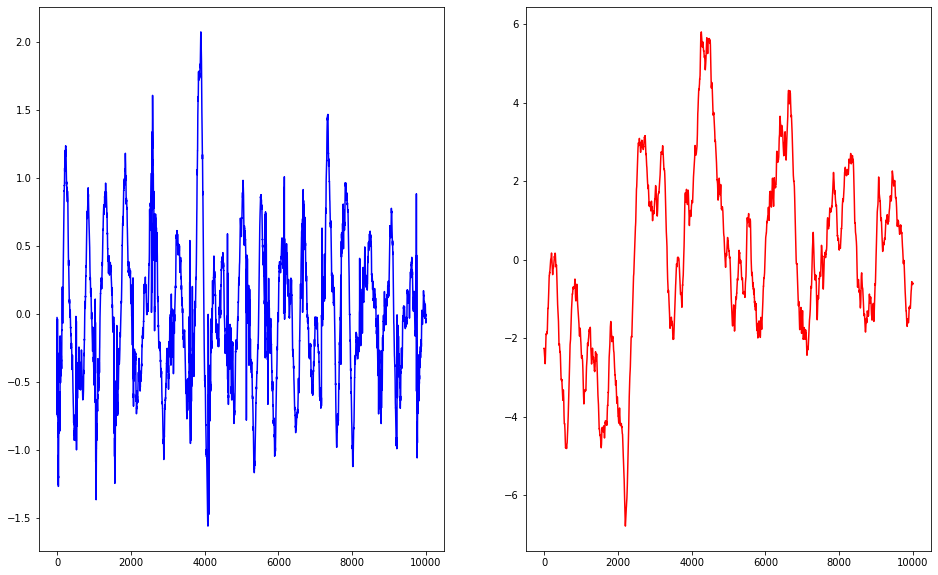

In [13]:
fig = plt.figure()
fig, ax_lst = plt.subplots(1, 2, figsize=(16,10))
ax_lst[0].plot(data_res[:10000,0], color="blue")
ax_lst[1].plot(sound_res[:10000,0], color="red")
# ax_lst[1].plot(np.arange(data_res.size(0)), data_res[:,1])
# ax_lst[0].plot(np.arange(sound_res.size(0)), data_res[:,1])

In [14]:
# start = 0
# end = 1000000
# fig = plt.figure()
# fig, sub = plt.subplots(2,4,figsize=(16,10))
# for ax in sub.flat:
#     ax.set(xlabel='frames', ylabel='magnitude')
# for i in range(sound_res.shape[-1]):
    
#     sub[i % 2][i // 2].plot(sound_res[start:end,i], color="blue")
#     sub[i % 2][i // 2].plot(data_res[start:end,i], color="red")
# # ax.plot(sound_res[start:end,0] - data_res[start:end,0], color='green')

# # self.writer.add_figure("Train/Plot", fig, data_res.size(0))
# plt.show(fig)

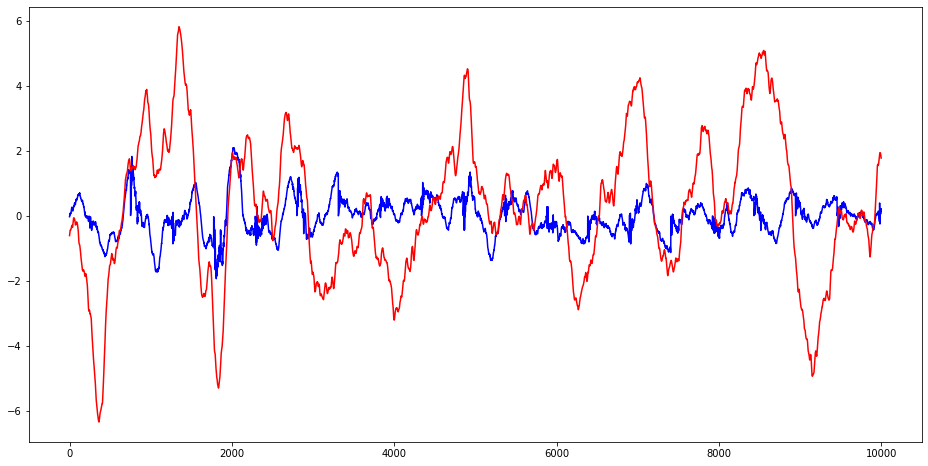

In [15]:
start = 10000
end = 20000
fig=plt.figure(figsize=(16,8))
ax = fig.add_subplot()
ax.plot(data_res[start:end,0], color="blue")
ax.plot(sound_res[start:end,0], color="red")
# self.writer.add_figure("Train/Plot", fig, data_res.size(0))
plt.show(fig)

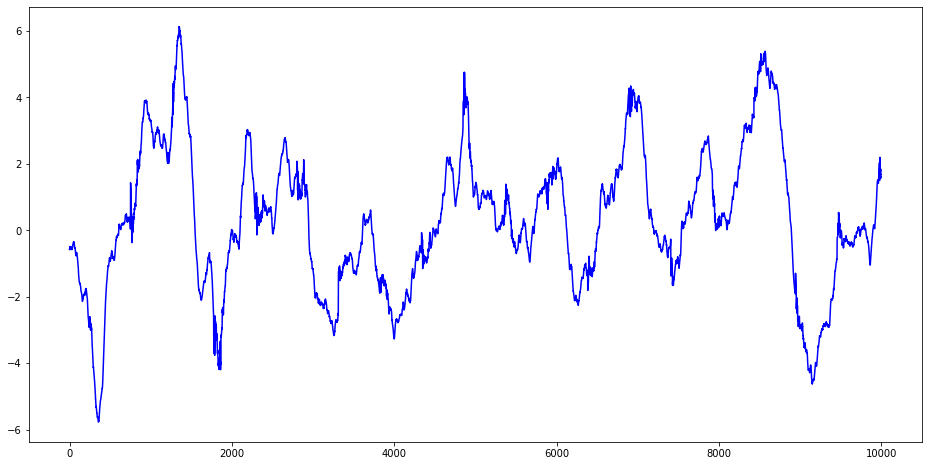

In [16]:
fig=plt.figure(figsize=(16,8))
ax = fig.add_subplot()
ax.plot(sound_res[start:end,0] - data_res[start:end,0], color="blue")
# self.writer.add_figure("Train/Plot", fig, data_res.size(0))
plt.show(fig)

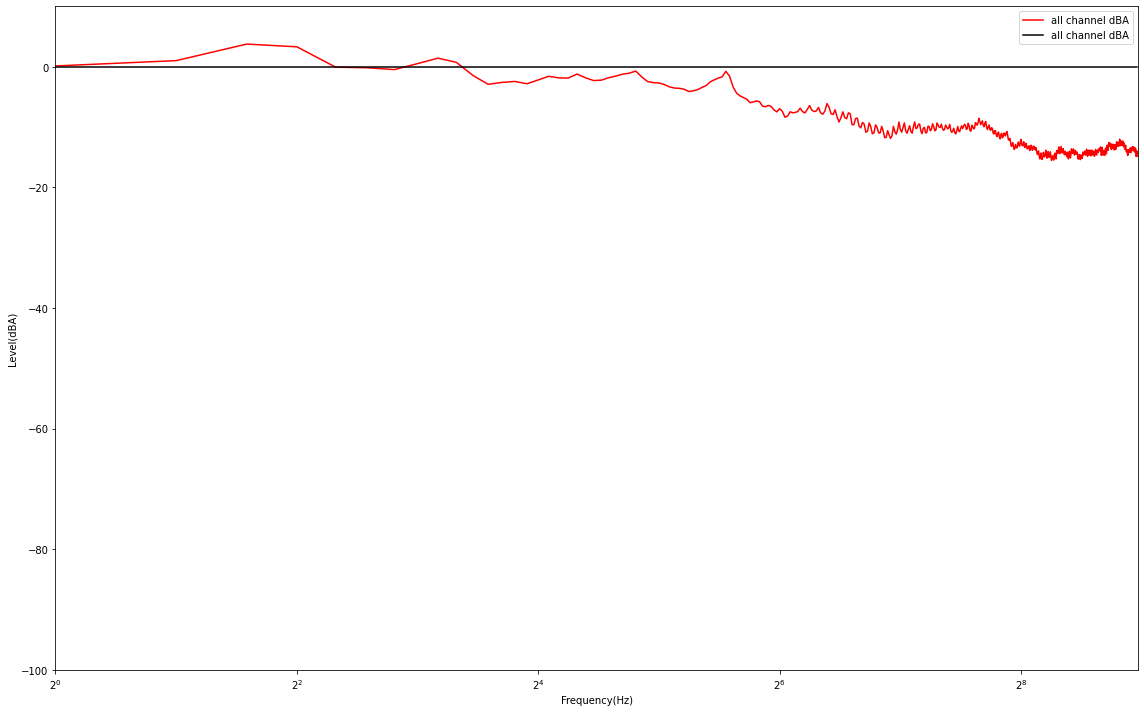

In [17]:
def dBA_metric(y, gt, freq, plot=True):
    """
    |args|
    :y: generated sound data, it's shape should be (time, 8)
    :gt: ground truth data, it's shape should be (time, 8)
    :freq: frequency range(low, high) ex) (5, 20)
    :plot: if True, plot graph of each channels
    """
    assert len(freq) == 2
    d = gt
    e = gt - y
    Tn = y.shape[0]
    K = 8
    M = 8
    """Post processing : performance metric and plots"""
    p_ref = 20e-6
    fs = 2000
    Nfft = fs
    noverlap = Nfft / 2
    t = (np.arange(Tn) / fs)[np.newaxis, :]
    #win = hann(fs, False)
    win = windows.hamming(fs)
    #autopower calculation
    D = np.zeros((int(Nfft/2 + 1), M))
    E = np.zeros((int(Nfft/2 + 1), M))
    for m in range(M):
        F, D[:,m] = welch(d[:, m], fs=fs, window=win, noverlap=noverlap, nfft=Nfft, return_onesided=True, detrend=False)
        F, E[:,m] = welch(e[:, m], fs=fs, window=win, noverlap=noverlap, nfft=Nfft, return_onesided=True, detrend=False)
    
    A = filter_A(F)
    AA = np.concatenate([[A]] * M, axis=0).transpose(1,0)
    D_A = D * AA ** 2 / p_ref ** 2
    E_A = E * AA ** 2 / p_ref ** 2
    
    # perfomance metric calculation
    D_A_dBA_Sum = np.zeros((1,M))
    E_A_dBA_Sum = np.zeros((1,M))
    
    freq_range = np.arange(freq[0], freq[1])
    result = []
    E_result = []
    for m in range(M):
        D_A_dBA_Sum[0, m] = 10 * np.log10(np.sum(D_A[freq_range, m]))
        E_A_dBA_Sum[0, m] = 10 * np.log10(np.sum(E_A[freq_range, m]))
        result.append(D_A_dBA_Sum[0,m] - E_A_dBA_Sum[0,m])
        E_result.append(E_A_dBA_Sum[0, m])
    result.append(np.array(np.mean(result)))
    avg_result = np.mean(result)
    E_result = np.array(np.mean(E_result))
    E_re = np.mean(np.array(E_result))
    
    gs = gridspec.GridSpec(nrows= 1, # row 몇 개 
                       ncols=1, # col 몇 개 
                      )
    fig = plt.figure(figsize=(16,10))
    if plot:
        F =     F[freq_range]
        D_A = D_A[freq_range]
        E_A = E_A[freq_range]
        da = np.mean(D_A, -1, keepdims=False)
        ea = np.mean(E_A, -1, keepdims=False)

        plt.subplot(gs[0])
        plt.plot(F, 10 * np.log10(da / ea + 1e-16), color="red", label='all channel dBA')
        plt.plot(F, np.zeros_like(F), color="black", label='all channel dBA')

        plt.legend()
        plt.ylim((-100, 10))
        plt.xlim((freq[0],freq[1]))
        plt.xscale('log', base=2)
        plt.xlabel('Frequency(Hz)')
        plt.ylabel('Level(dBA)')
        plt.tight_layout()
        plt.show()
        # print(np.mean(10 * np.log10(da)) - np.mean(10 * np.log10(ea)))
        # 원래 score 구하는 건 각 채널별로 평균내서 뺀 것
        # 위 score는 채널 전체 평균낸것
    return avg_result, E_re
if config.filter:
    low, high = int(config.range.split('~')[0])//2, int(config.range.split('~')[0])*2
else:
    low = 1
    high = 500
score, _ = dBA_metric(data_res[:], sound_res[:] ,(low, high),True)

In [18]:
score

-13.294037579320992

In [19]:
x.numpy().shape, y.numpy().shape, data_res.numpy().shape, sound_res.numpy().shape

AttributeError: 'list' object has no attribute 'numpy'

In [ ]:
da = {
    'x':x.numpy(),
    'y':y.numpy(),
    "y'":data_res.numpy(),
    'sound':sound_res.numpy(),
    'path_01': np.array(pickle.load(open(os.path.join(data_path,'transfer_f.pickle'),'rb')))
}

In [ ]:
joblib.dump(da,open(f'{config.range}_dBA{score:0.4}_data.joblib', 'wb'))

In [ ]:
a = (sound_res[1490000:1500000] - data_res[1490000:1500000]) ** 2
b = (a.mean(dim=0)).numpy()
print(b)
print(b.mean())
print('----------------------------------------------------------')
a = (sound_res[1000000:1010000] - data_res[1000000:1010000]) ** 2
b = (a.mean(dim=0)).numpy()
print(b)
print(b.mean())

In [ ]:
def write_wav(data, sr=8192, name='test_gen'):
    data = data.type(torch.float32).numpy()
    data = data - np.min(data)
    data /= np.max(data)
    write(name+'.wav', sr, data)
    return data


In [ ]:
write_wav(sound_res[start:end,0], name='original')

In [ ]:
write_wav(sound_res[start:end,0] - data_res[start:end,0])

In [ ]:
ipd.Audio('test_gen.wav',normalize=False) # load a local WAV file

In [ ]:
ipd.Audio('original.wav',normalize=False) # load a local WAV file